# Imports

In [ ]:
!pip install tensorflow-gpu==2.3.1
import tensorflow as tf
import numpy as np
import os
import pickle

from tensorflow.keras import backend

In [4]:
tf.compat.v1.disable_eager_execution() #Eager exectution doesn't work with this VAE, operations can't be calculated before hand here.

class VAE:
  def __init__(
      self,
      input_shape,
      conv_filters,
      conv_kernels,
      conv_strides,
      latent_dim_space):
    # Initial bunch of provided inputs
    self.input_shape = input_shape
    self.conv_filters = conv_filters
    self.conv_kernels = conv_kernels
    self.conv_strides = conv_strides
    self.latent_dim_space = latent_dim_space
    self.recon_loss_weight = 1000

    # Initial state of encoder, decoder, model
    self.encoder = None
    self.decoder = None
    self.model = None
    
    # Params derived from one's supplied
    self.num_conv_layers = len(self.conv_filters)
    self.prev_shape = None
    
    self._model_input = None

    self._build()

  # Provides the build summary for all components of the VAE
  def summary(self):
    self.encoder.summary()
    self.decoder.summary()
    self.model.summary()

  # Build all the components of the VAE
  def _build(self):
    self._build_encoder()
    self._build_decoder()
    self._build_vae()

  # The preprocesssed data needs to be fitted to the model so the model can learn from it.
  def train(self, x_train, batch_size, num_epochs):
    self.model.fit(x_train,
                   x_train,
                   batch_size = batch_size,
                   epochs = num_epochs,
                   shuffle=True)

  # Build the VAE
  def _build_vae(self):
    model_input = self._model_input
    model_output = self.decoder(self.encoder(model_input))
    self.model = tf.keras.Model(model_input, model_output, name="vae")

  # Build vae's Encoder
  def _build_encoder(self):
    encoderInput = self._add_encoder_input()
    conv_layers = self._add_conv_layers(encoderInput)
    encoderOutput = self._add_bottleneck(conv_layers)
    self._model_input = encoderInput
    self.encoder = tf.keras.Model(encoderInput, encoderOutput, name="encoder")

  # Add input layer to the encoder
  def _add_encoder_input(self):
    return tf.keras.layers.Input(shape= self.input_shape, name="encoder_input")

  # Prepare a final output layer for vae based on latent_dim
  def _add_bottleneck(self, conv_layers):
    x = conv_layers
    """Flatten the data and prepare the final output layer for encoder with Gaussian sampling"""

    self.prev_shape = backend.int_shape(x)[1:] #[batch_size, width, height, Num_channels]
    x = tf.keras.layers.Flatten()(x)

    """Encoding a pt. in latent data_space : z = mu + Summation[epsilon]"""

    # mean
    self.mu = tf.keras.layers.Dense(self.latent_dim_space, name="mu")(x)
    # log variance
    self.log_var = tf.keras.layers.Dense(self.latent_dim_space, name="log_var")(x)

    def sample_pt_from_normal_dist(args):
      mu, log_var = args
      #mean = 0 and stddev = 1--> to get standard normal distribution
      epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(self.mu), mean=0.0, stddev=1.0)
      sampled_point = mu + tf.keras.backend.exp(log_var / 2) * (epsilon)
      return sampled_point

    x = tf.keras.layers.Lambda(sample_pt_from_normal_dist, name="Encoder_Output")([self.mu, self.log_var])
    return x

  # Create all conv blocks for encoder based on num_conv_layers requested
  def _add_conv_layers(self, encoderInput):
    x = encoderInput
    for layer_idx in range(self.num_conv_layers):
      x = self._add_conv_layer(layer_idx, x)
    return x

    """Adds a conv block to a graph of layers which contain 
  multiple conv2d + ReLU + batch_normalizaton"""
  def _add_conv_layer(self, layer_idx, x):
    conv_layer = tf.keras.layers.Conv2D(
        filters = self.conv_filters[layer_idx],
        kernel_size = self.conv_kernels[layer_idx],
        strides = self.conv_strides[layer_idx],
        padding = "same",
        name=f"Encoder_Conv_Layer-{layer_idx+1}",
    )

    x = conv_layer(x)
    x = tf.keras.layers.ReLU(name=f"Encoder_ReLU_{layer_idx + 1}")(x)
    x = tf.keras.layers.BatchNormalization(name=f"Encoder_BatchNormalization_{layer_idx+1}")(x)

    return x

  
  # Build vae's decoder
  def _build_decoder(self):
    decoderInput = self._add_decoder_input()
    dense_layer = self._add_dense_layer(decoderInput)
    reshape_layer = self._add_reshape_layer(dense_layer)
    conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
    decoderOutput = self._add_decoder_output(conv_transpose_layers)
    self.decoder = tf.keras.Model(decoderInput, decoderOutput, name="decoder")

  # Add input layer to the decoder
  def _add_decoder_input(self):
    return tf.keras.layers.Input(shape=self.latent_dim_space, name="decoder_input")

  # Add dense layer to the decoder
  def _add_dense_layer(self, decoderInput):
    num_units = np.prod(self.prev_shape) #prev_shape = [x,y,z] -->prod = x*y*z
    return tf.keras.layers.Dense(units=num_units, name="decoder_dense_layer")(decoderInput)

  # Reshape the layer to match target shape needed by decoder
  def _add_reshape_layer(self, dense_layer):
    reshape_layer = tf.keras.layers.Reshape(target_shape=self.prev_shape)(dense_layer)
    return reshape_layer

  # Add convolution transpose block to re-create image from latent dims.
  def _add_conv_transpose_layers(self, x):
    """Add convolutional transpose blocks"""
    # We need to ignore first conv layer we are going in reverse order of conv_layers used
    # in encoder.
    for layer_idx in reversed(range(1,self.num_conv_layers)):
      x = self._add_conv_transpose_layer(layer_idx, x)
    return x

  # Add specific conv_transpose_layer in a specific position
  def _add_conv_transpose_layer(self, layer_idx, x):
    layer_num = self.num_conv_layers - layer_idx

    conv_trans_layer = tf.keras.layers.Conv2DTranspose(
        filters = self.conv_filters[layer_idx],
        kernel_size = self.conv_kernels[layer_idx],
        strides = self.conv_strides[layer_idx],
        padding = "same",
        name=f"decoder_conv_transpose_layer_{layer_num}"
    )

    x = conv_trans_layer(x)
    x = tf.keras.layers.ReLU(name=f"decoder_ReLU_{layer_num}")(x)
    x = tf.keras.layers.BatchNormalization(name=f"decoder_batchnormalization_{layer_num}")(x)
    return x

  # Add final output layer to the decoder
  def _add_decoder_output(self, x):
    conv_trans_layer = tf.keras.layers.Conv2DTranspose(
        filters = self.conv_filters[0],
        kernel_size = self.conv_kernels[0],
        strides = self.conv_strides[0],
        padding="same",
        name=f"decoder_final_conv_trans_layer_{self.num_conv_layers}",
    )

    x = conv_trans_layer(x)
    outputLayer = tf.keras.layers.Activation("sigmoid", name=f"decoder_output_layer")(x)
    return outputLayer

  # Compile the model
  def compile(self, learning_rate=0.0001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    self.model.compile(optimizer = optimizer, 
                       loss = self._calculate_combined_loss, 
                       metrics=[self._calculate_reconstruction_loss,
                                self._calculate_kl_loss])

  # Reconstruction Loss
  def _calculate_reconstruction_loss(self, y_target, y_pred):
    error = y_target - y_pred
    recon_loss = tf.keras.backend.mean(tf.keras.backend.square(error), axis=[1,2,3])
    return recon_loss

  # Kullback-Libler Loss
  def _calculate_kl_loss(self, y_target, y_pred):
    # kl_loss = 1/2 * (Summation[ 1 + log(variance) - mean^2 - variance^2]), - -->sign used because we are calculating loss
    kl_loss = - 0.5 * tf.keras.backend.sum(1 + self.log_var - tf.keras.backend.square(self.mu) - 
                                           tf.keras.backend.exp(self.log_var), 
                                           axis=1)
    return kl_loss

  def _calculate_combined_loss(self, y_target, y_pred):
    recon_loss = self._calculate_reconstruction_loss(y_target, y_pred)
    kl_loss = self._calculate_kl_loss(y_target, y_pred)
    combined_loss = self.recon_loss_weight * recon_loss + kl_loss

    return combined_loss



  # Save the model
  def save(self, save_folder="."):
    self._create_save_dir(save_folder)
    self._save_params(save_folder)
    self._save_weights(save_folder)
  
  def _create_save_dir(self, sfolder):
    if not os.path.exists(sfolder):
      os.makedirs(sfolder)

  # Params to be saved
  def _save_params(self, sfolder):
    params = [self.input_shape,    # Initial input model will get
              self.conv_filters,  # List containing num of filters for each layer
              self.conv_kernels, # List containing num of kernels for each layer
              self.conv_strides,  # List containing strides for each layer
              self.latent_dim_space,
              ]
    save_path = os.path.join(sfolder, "params.pkl")
    with open(save_path, "wb")  as f:
      pickle.dump(params, f)

  # Weights to be saved
  def _save_weights(self, sfolder):
     save_path = os.path.join(sfolder, "weights.h5")
     self.model.save_weights(save_path)

  def load(cls, sfolder="."):
    param_path = os.path.join(sfolder, "params.pkl")
    with open(param_path, "rb") as f:
      params = pickle.load(f)
    vae = VAE(*params)
    weights_path = os.path.join(sfolder, "weights.h5")
    vae.load_weights(weights_path)
    return vae

  def load_weights(self, weights_path):
    self.model.load_weights(weights_path)

  def reconstruct(self, images):
      latent_representations = self.encoder.predict(images)
      reconstructed_images = self.decoder.predict(latent_representations)
      return reconstructed_images, latent_representations

        
    



In [6]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype("float32") / 255
x_test = x_test.reshape(x_test.shape + (1,))

print(x_train.shape)

print(x_test.shape)


4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [7]:
LEARNING_RATE = 0.005
BATCH_SIZE = 32


vAE = VAE(
    input_shape=(28,28,1),
    conv_filters=(32,64,64,64),
    conv_kernels=(3,3,3,3),
    conv_strides=(1,2,2,1),
    latent_dim_space=2
)

#vAE.summary()
vAE.compile(LEARNING_RATE)

In [8]:
EPOCHS=100
vAE.train(x_train=x_train, batch_size=BATCH_SIZE, num_epochs=EPOCHS)

Train on 60000 samples
Epoch 1/100
60000/60000 [==============================] - 39s 656us/sample - loss: 48.4044 - _calculate_reconstruction_loss: 0.0415 - _calculate_kl_loss: 6.9204
Epoch 2/100
60000/60000 [==============================] - 39s 648us/sample - loss: 38.1805 - _calculate_reconstruction_loss: 0.0334 - _calculate_kl_loss: 4.8093
Epoch 3/100
60000/60000 [==============================] - 39s 651us/sample - loss: 36.7978 - _calculate_reconstruction_loss: 0.0319 - _calculate_kl_loss: 4.9262
Epoch 4/100
60000/60000 [==============================] - 42s 694us/sample - loss: 36.3248 - _calculate_reconstruction_loss: 0.0313 - _calculate_kl_loss: 4.9999
Epoch 5/100
60000/60000 [==============================] - 38s 639us/sample - loss: 35.8564 - _calculate_reconstruction_loss: 0.0308 - _calculate_kl_loss: 5.0325
Epoch 6/100
60000/60000 [==============================] - 40s 665us/sample - loss: 35.6449 - _calculate_reconstruction_loss: 0.0306 - _calculate_kl_loss: 5.0677
Epoch

In [32]:
from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        vAE.summary()

In [9]:
vAE.save("model") #Rem to create the model folder in the cwd

In [10]:
from matplotlib import pyplot as plt
def select_images(images, labels, num_images=10):
  sample_images_idx = np.random.choice(range(len(images)), num_images)
  sample_images = images[sample_images_idx]
  sample_labels = labels[sample_images_idx]
  return sample_images, sample_labels

def plot_reconstructed_images(images, resconstructed_images):
  figure = plt.figure(figsize=(15,3))
  num_images = len(images)
  for itr, (image, reconstructed_image) in enumerate(zip(images, resconstructed_images)):
    image = image.squeeze()
    ax = figure.add_subplot(2, num_images, itr+1)
    ax.imshow(image)

    reconstructed_image = reconstructed_image.squeeze()
    # https://www.statology.org/fig-add-subplot/ #
    ax = figure.add_subplot(2, num_images, itr+num_images+1)
    ax.imshow(image)

  plt.show()



def plot_images_encoded_in_latent_space(latent_representations, sample_labels):
    plt.figure(figsize=(10, 10))
    plt.scatter(latent_representations[:, 0],
                latent_representations[:, 1],
                cmap="rainbow",
                c=sample_labels,
                alpha=0.75,
                s=2)
    plt.colorbar()
    plt.show()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


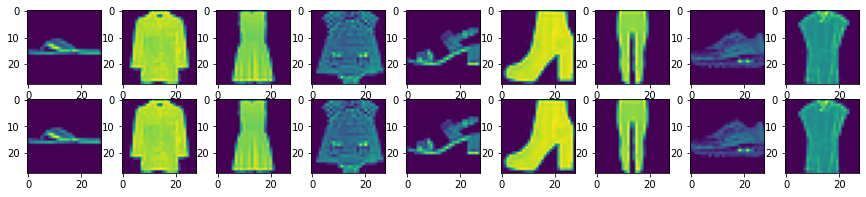

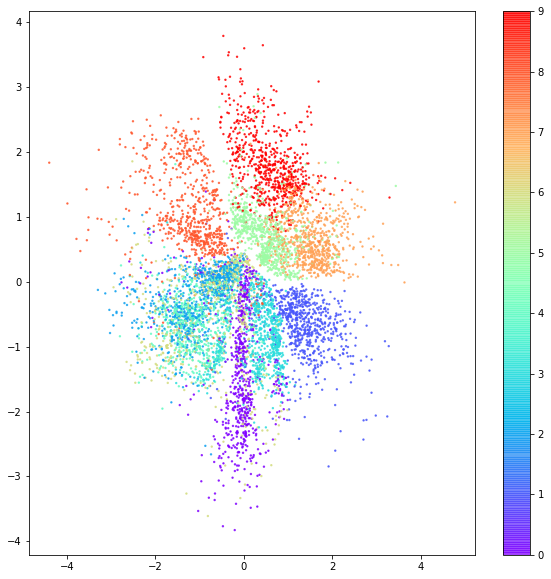

In [11]:
num_sample_images = 9
sample_images, _ = select_images(x_test, y_test, num_sample_images)
reconstructed_images, _ = vAE.reconstruct(sample_images)
plot_reconstructed_images(sample_images, reconstructed_images)

num_images = 7000
sample_images, sample_labels = select_images(x_test, y_test, num_images)
_, latent_representations = vAE.reconstruct(sample_images)
plot_images_encoded_in_latent_space(latent_representations, sample_labels)